In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import cv2 

In [3]:
import os
import cv2
import numpy as np

def load_images_from_directory(folder_path, image_size=(128, 128)):
    images = []
    filenames = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.bmp'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)
                filenames.append(filename)

    images = np.array(images) / 255.0  # Normalize pixel values
    return images, filenames

# Path to your folder
folder_path = '/Users/shreyavidyadhar/Downloads/PH2/trainx/'

# Load images
X, image_names = load_images_from_directory(folder_path)

print("Loaded images shape:", X.shape)
print("First few image filenames:", image_names[:5])


Loaded images shape: (200, 128, 128, 3)
First few image filenames: ['IMD.002.bmp', 'IMD.003.bmp', 'IMD.004.bmp', 'IMD.005.bmp', 'IMD.006.bmp']


In [4]:
import os
import cv2
import numpy as np

def load_images_as_train_x(folder_path, image_size=(128, 128)):
    images = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.bmp'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)

    train_x = np.array(images, dtype=np.float32) / 255.0  # Normalize
    return train_x

# ✅ Your path to the directory with images
path_to_images = '/Users/shreyavidyadhar/Downloads/PH2/trainx/'

# ✅ Load and name as train_x
train_x = load_images_as_train_x(path_to_images)

print("train_x shape:", train_x.shape)


train_x shape: (200, 128, 128, 3)


In [5]:
def load_images_as_train_y(folder_path, image_size=(128, 128)):
    images = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.bmp'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
            if img is not None:
                img = cv2.resize(img, image_size)
                img = np.expand_dims(img, axis=-1)  # Make shape (H, W, 1)
                images.append(img)

    train_y = np.array(images, dtype=np.float32) / 255.0  # Normalize
    return train_y


In [6]:
train_y = load_images_as_train_y('/Users/shreyavidyadhar/Downloads/PH2/trainy/')
print(train_y.shape)  # Should be (N, 128, 128, 1)


(200, 128, 128, 1)


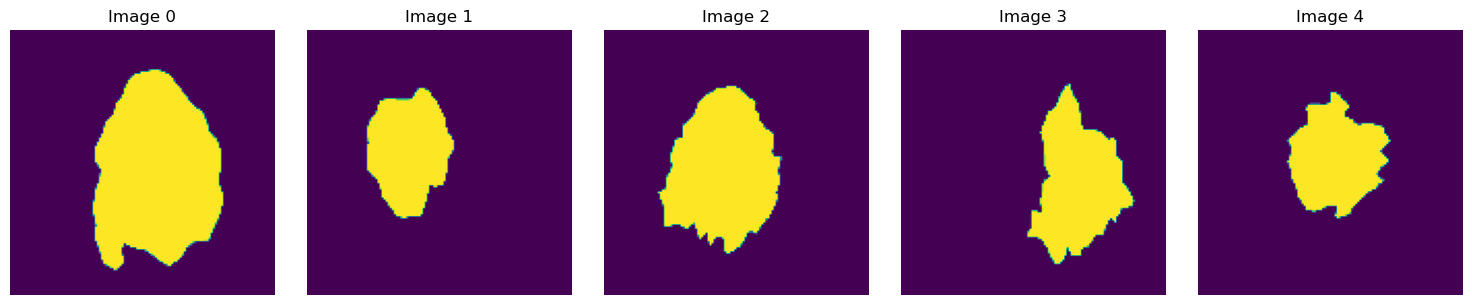

In [7]:
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_y[i])
    plt.axis('off')
    plt.title(f"Image {i}")
plt.tight_layout()
plt.show()


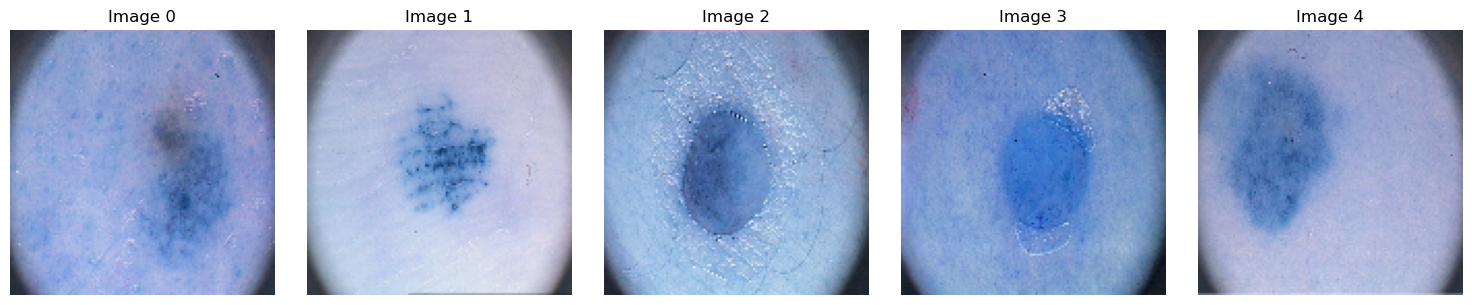

In [8]:
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_x[i])
    plt.axis('off')
    plt.title(f"Image {i}")
plt.tight_layout()
plt.show()


In [9]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create model
model = unet_model(input_size=(128, 128, 3))

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_8[0][0]  

 Total params: 118,273 (462.00 KB)

 Trainable params: 118,273 (462.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.fit(train_x, train_y, batch_size=8, epochs=20, validation_split=0.1)


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.6327 - loss: 0.6414 - val_accuracy: 0.4266 - val_loss: 0.6988
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.7183 - loss: 0.5940 - val_accuracy: 0.4266 - val_loss: 1.1937
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.7096 - loss: 0.5287 - val_accuracy: 0.4266 - val_loss: 0.7924
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7136 - loss: 0.5030 - val_accuracy: 0.4266 - val_loss: 0.8229
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.6867 - loss: 0.5228 - val_accuracy: 0.4359 - val_loss: 0.7527
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.7206 - loss: 0.5126 - val_accuracy: 0.6388 - val_loss: 0.8044
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.7617 - loss: 0.4976 - val_accuracy: 0.5907 - val_loss: 0.7166
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.7526 - loss: 0.5053 - val_accuracy: 0.5131 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(5, 128, 128, 3))
  warnings.warn(msg)


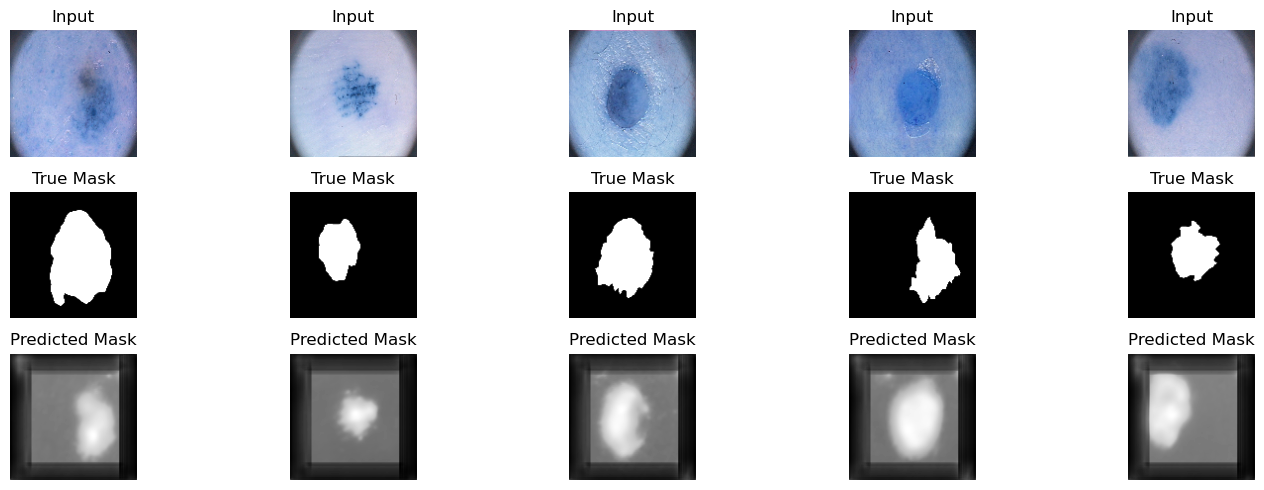

In [11]:
preds = model.predict(train_x[:5])

# Show prediction vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(train_x[i])
    plt.title("Input")
    plt.axis('off')

    plt.subplot(3, 5, i + 6)
    plt.imshow(train_y[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(3, 5, i + 11)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam

sm.set_framework('tf.keras')

model1 = sm.Unet(
    backbone_name='efficientnetb4',  # ← more powerful than resnet34
    input_shape=(128, 128, 3),
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)

model1.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


AttributeError: module 'keras.api.utils' has no attribute 'generic_utils'

In [ ]:
!pip install -U segmentation-models


In [ ]:
!pip install segmentation-models-tf



In [24]:
import segmentation_models_tf as smtf
from tensorflow.keras.optimizers import Adam

# Build model with pretrained EfficientNetB4 encoder
model = smtf.Unet(
    backbone_name='efficientnetb4',

    input_shape=(128, 128, 3),
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


ModuleNotFoundError: No module named 'segmentation_models_tf'

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    b = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u3 = layers.UpSampling2D((2, 2))(b)
    u3 = layers.concatenate([u3, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u2 = layers.UpSampling2D((2, 2))(c6)
    u2 = layers.concatenate([u2, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u1 = layers.UpSampling2D((2, 2))(c7)
    u1 = layers.concatenate([u1, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model1 = models.Model(inputs=[inputs], outputs=[outputs])
    return model1


In [28]:
model1 = build_unet(input_shape=(128, 128, 3))
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
               loss='binary_crossentropy',
               metrics=['accuracy'])

model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_4[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_17[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 768)              │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │  1,769,728 │ concatenate_2[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_19[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_20[0][0] 

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Build and compile the model
model1 = build_unet(input_shape=(128, 128, 3))
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

# Show model architecture
model1.summary()

# Reshape labels if needed
train_y = train_y.reshape(-1, 128, 128, 1)

# Train the model
model1.fit(train_x, train_y, batch_size=8, epochs=20, validation_split=0.1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_26[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_28[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_30[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_32[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 32, 32,    │          0 │ conv2d_33[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 32, 32,    │          0 │ up_sampling2d_5[… │
│ (Concatenate)       │ 768)              │            │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │  1,769,728 │ concatenate_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_34[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 64, 64,    │          0 │ conv2d_35[0][0] 

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_43']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6509 - loss: 0.6608 - val_accuracy: 0.4266 - val_loss: 0.7937
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6932 - loss: 0.5999 - val_accuracy: 0.4266 - val_loss: 0.7237
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6871 - loss: 0.5801 - val_accuracy: 0.4266 - val_loss: 0.8084
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6998 - loss: 0.5066 - val_accuracy: 0.4267 - val_loss: 0.8833
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6933 - loss: 0.5115 - val_accuracy: 0.6341 - val_loss: 0.7166
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7579 - loss: 0.4894 - val_accuracy: 0.5478 - val_loss: 0.7530
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7462 - loss: 0.4956 - val_accuracy: 0.6831 - val_loss: 0.7823
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7732 - loss: 0.4579 - val_accuracy: 0.6564 - val_loss: 0.8631
Epo

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_43']
Received: inputs=Tensor(shape=(5, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


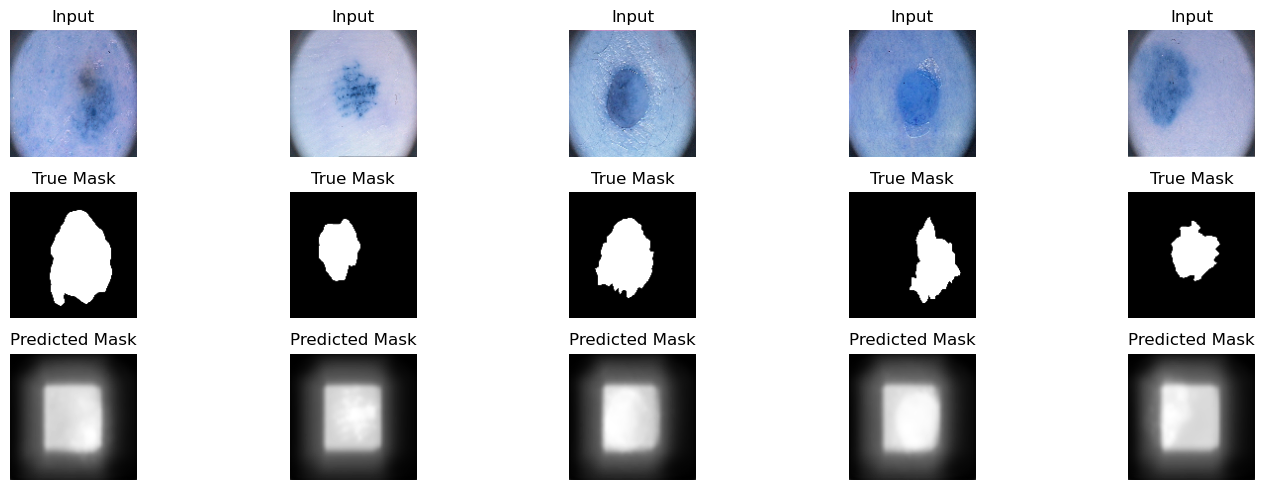

In [32]:
preds = model1.predict(train_x[:5])

# Show prediction vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(train_x[i])
    plt.title("Input")
    plt.axis('off')

    plt.subplot(3, 5, i + 6)
    plt.imshow(train_y[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(3, 5, i + 11)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
model.fit(train_x, train_y, batch_size=8, epochs=25, validation_split=0.1)